In [526]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt

In [527]:
tickers = ['AZN', 'GSK', 'HSBA', 'BP', 'SHEL', 'BARC', 'LSEG', 'RIO', 'BATS', 'REL', 'DGE']
tickers = [ticker + '.L' for ticker in tickers]

endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(10*365)

returnsData = yf.download(tickers,start=startDate,end=endDate,interval='1d')
returnsData = returnsData['Adj Close']

[*********************100%***********************]  11 of 11 completed


In [528]:
portfolioReturns = returnsData.pct_change().dropna()

/var/folders/33/_ft973790qv2wpzyrpc3p2fr0000gn/T/ipykernel_96280/670730958.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  portfolioReturns = returnsData.pct_change().dropna()


In [529]:
class MeanVarianceOptimisation:
    def __init__(self, portfolioReturns, numPortfolios=10000, riskFreeRate=0.04):
        self.portfolioReturns = portfolioReturns
        self.meanReturns = portfolioReturns.mean()
        self.numPortfolios = numPortfolios
        self.numStocks = len(portfolioReturns.columns)
        self.results = np.zeros((3, numPortfolios))
        self.weights = np.zeros((self.numStocks, numPortfolios))
        self.riskFreeRate = riskFreeRate
        self.tickers = np.array(portfolioReturns.columns)
    
    
    def generatePortfolios(self):
        for j in range(self.numPortfolios):
            randomWeights = np.random.random(self.numStocks)
            randomWeights /= np.sum(randomWeights)
            self.weights[:,j] = randomWeights
            
            weightedPfReturns = np.dot(self.portfolioReturns,randomWeights)
            pfReturn = np.sum(self.meanReturns*randomWeights) * 252
            downsideReturns = weightedPfReturns[weightedPfReturns < self.riskFreeRate]
            downsideDev = np.std(downsideReturns) * np.sqrt(252)

            self.results[0,j] = downsideDev
            self.results[1,j] = pfReturn
            self.results[2,j] = (self.results[1,j] - self.riskFreeRate) / self.results[0,j]

        optimalSortinoLoc = np.argmax(self.results[2,:])
        self.optimalSortino = self.results[2,optimalSortinoLoc]
        self.optimalReturn = self.results[1,optimalSortinoLoc]
        self.optimalDownsideDev = self.results[0, optimalSortinoLoc]
        self.optimalWeights = self.weights[:, optimalSortinoLoc]
    
    def plot(self):
        vmin = round(self.results[2,:].min(),1)
        vmax = round(self.optimalSortino,1)
        levels = np.around(np.linspace(vmin,vmax,5),2)
        plt.scatter(self.results[0,:], self.results[1,:], c=self.results[2,:], cmap='viridis',marker='o')
        plt.scatter(self.optimalDownsideDev,self.optimalReturn,c='red',marker='x',label='Optimal Portfolio')
        plt.title('Efficient Frontier')
        plt.xlabel('Downside Deviation')
        plt.ylabel('Annualised Returns')
        plt.colorbar(label='Sortino Ratio', ticks=levels)
        plt.clim(vmin,vmax)
        plt.show()

    def getOptimalResults(self):
        return print(f"Sortino Ratio: {self.optimalSortino:.2f}\n" +
                f"Expected Annualised Return: {self.optimalReturn*100:.1f}%\n" +
                f"Downside Deviation: {self.optimalDownsideDev:.2f}")
    
    def getWeights(self):
        pairedWeights = np.column_stack((self.tickers, self.optimalWeights))
        for ticker, weight in pairedWeights:
            print(f"{ticker}: {float(weight)*100:.1f}%")

In [530]:
test = MeanVarianceOptimisation(portfolioReturns)

In [531]:
test.generatePortfolios()

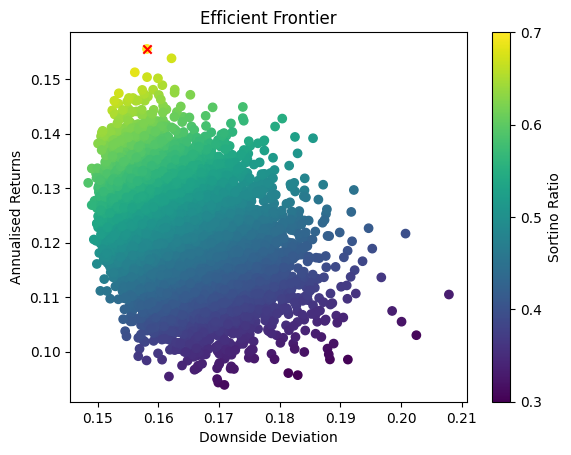

In [532]:
test.plot()

In [533]:
test.getWeights()

AZN.L: 21.5%
BARC.L: 9.7%
BATS.L: 5.1%
BP.L: 2.8%
DGE.L: 0.0%
GSK.L: 4.0%
HSBA.L: 5.2%
LSEG.L: 25.7%
REL.L: 12.1%
RIO.L: 12.8%
SHEL.L: 1.1%


In [534]:
test.getOptimalResults()

Sortino Ratio: 0.73
Expected Annualised Return: 15.6%
Downside Deviation: 0.16
